In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy import stats
from tsfresh.feature_extraction import extract_features
from tqdm import tqdm
tqdm.pandas(desc="apply progress")

In [2]:
data_dir = "/Users/hidehisa/.kaggle/competitions/plasticc/"
os.listdir(data_dir)

['test_set_metadata.csv.zip',
 '.DS_Store',
 'data_note.pdf',
 'test_set_sample.csv.zip',
 'training_set.csv',
 'test_set_metadata.csv',
 'train_with_cluster.csv',
 'data_note.pdf.zip',
 'training_set_metadata.csv',
 'training_set.csv.zip',
 'sample_submission.csv.zip',
 'sample_submission.csv']

# データ読み込み

In [15]:
meta = pd.read_csv(f"{data_dir}training_set_metadata.csv")
train = pd.read_csv(f"{data_dir}training_set.csv")

In [4]:
meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [5]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected,cluster
0,615,59750.4229,2,-544.810303,3.622952,1,2
1,615,59750.4306,1,-816.434326,5.553370,1,2
2,615,59750.4383,3,-471.385529,3.801213,1,2
3,615,59750.4450,4,-388.984985,11.395031,1,2
4,615,59752.4070,2,-681.858887,4.041204,1,2


# 特徴作成関数

In [86]:
def cluster_mean_diff(df):
    new_df = df.groupby(["object_id", "cluster"]).agg({
        "flux": ["mean", "max", "min"]
    })
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns.tolist()])
    new_df["normalized_mean"] = new_df["flux_mean"] / (new_df["flux_max"] - new_df["flux_min"])
    new_df.reset_index(inplace=True)
    return new_df.groupby("object_id").agg({
        "normalized_mean": "std"
    })

In [19]:
def passband_std_difference(df):
    std_df = df.groupby(["object_id", "cluster", "passband"]).agg({
        "flux": "std"
    }).reset_index().groupby(
        ["object_id", "passband"]
    )["flux"].mean().reset_index()
    std_df_max = std_df.groupby("object_id")["flux"].max()
    std_df_min = std_df.groupby("object_id")["flux"].min()
    return (std_df_max / std_df_min).reset_index()

In [176]:
def linear_slope(df):
    new_df = df.groupby(["object_id", "cluster", "passband"]).agg({
        "flux": ["max", "min"]
    })
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])
    new_df.reset_index(inplace=True)
    new_df["flux_range"] = new_df["flux_max"] - new_df["flux_min"]
    new_df = pd.merge(df, new_df, how="left", on=["object_id", "cluster", "passband"])
    new_df["flux_normalized"] = new_df["flux"] / new_df["flux_range"]
    lr = LinearRegression()
    template = pd.DataFrame(
        {
            "object_id": new_df.object_id.unique(),
            "passband0": 0,
            "passband1": 0,
            "passband2": 0,
            "passband3": 0,
            "passband4": 0,
            "passband5": 0
        }
    )
    for objid in new_df.object_id.unique():
        obj_df = new_df.query("object_id == @objid")[["mjd", "cluster", "passband", "flux_normalized"]]
        passbands = [[] for _ in range(6)]
        for cl in obj_df.cluster.unique():
            cluster_df = obj_df.query("cluster == @cl")
            for ps in cluster_df.passband.unique():
                ps_df = cluster_df.query("passband == @ps")
                if ps_df.shape[0] <= 1:
                    passbands[ps].append(0)
                    continue
                lr.fit(ps_df["mjd"].values.reshape([-1, 1]), ps_df["flux_normalized"].values.reshape([-1, 1]))
                passbands[ps].append(np.abs(lr.coef_)[0][0])
        passbands = [np.mean(p) for p in passbands]
        for i, ps in enumerate(passbands):
            template.loc[template.query("object_id == @objid").index, f"passband{i}"] = ps
    return template

In [4]:
new_df = train.groupby(["object_id", "cluster", "passband"]).agg({
    "flux": ["min", "max"]
})
new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])

In [5]:
new_df.reset_index(inplace=True)
new_df["flux_range"] = new_df["flux_max"] - new_df["flux_min"]
new_df = pd.merge(train, new_df, how="left", on=["object_id", "cluster", "passband"])
new_df["flux_normalized"] = new_df["flux"] / new_df["flux_range"]
new_df.head(20)

,object_id,mjd,passband,flux,flux_err,detected,cluster,flux_min,flux_max,flux_range,flux_normalized
0,615,59750.4229,2,-544.810303,3.622952,1,2,-681.858887,604.344543,1286.203430,-0.423580
1,615,59750.4306,1,-816.434326,5.553370,1,2,-1100.440063,659.486694,1759.926757,-0.463902
2,615,59750.4383,3,-471.385529,3.801213,1,2,-524.954590,373.986511,898.941101,-0.524379
3,615,59750.4450,4,-388.984985,11.395031,1,2,-422.184509,374.446442,796.630951,-0.488288
4,615,59752.4070,2,-681.858887,4.041204,1,2,-681.858887,604.344543,1286.203430,-0.530133
5,615,59752.4147,1,-1061.457031,6.472994,1,2,-1100.440063,659.486694,1759.926757,-0.603126
6,615,59752.4224,3,-524.954590,3.552751,1,2,-524.954590,373.986511,898.941101,-0.583970
7,615,59752.4334,4,-393.480225,3.599346,1,2,-422.184509,374.446442,796.630951,-0.493930
8,615,59752.4435,5,-355.886780,10.421921,1,2,-422.815094,370.346283,793.161377,-0.448694
9,615,59767.2968,2,-548.013550,3.462291,1,2,-681.858887,604.344543,1286.203430,-0.426071


In [8]:
lr = LinearRegression()
def get_coef_(x):
    if x.shape[0] <= 1:
        return 0
    lr.fit(x.mjd.values.reshape([-1, 1]), x.flux_normalized.values.reshape([-1, 1]))
    return lr.coef_[0][0]
new_df.groupby(["object_id", "cluster", "passband"], as_index=False)["object_id", "cluster", "passband", "mjd", "flux_normalized"].progress_apply(lambda x: get_coef_(x))


apply progress: 100%|██████████| 148786/148786 [01:15<00:00, 1961.95it/s]

object_id  cluster  passband
615        0        0           0.001850
                    1           0.004352
                    2           0.004491
                    3           0.004355
                    4           0.003426
                    5           0.003277
           1        0          -0.002404
                    1           0.002472
                    2           0.003024
                    3           0.003143
                    4           0.003169
                    5           0.002648
           2        0          -0.004565
                    1           0.002323
                    2           0.002705
                    3           0.003099
                    4           0.003242
                    5           0.002980
713        0        0          -0.007082
                    1          -0.005444
                    2          -0.006509
                    3          -0.006501
                    4          -0.005050
                    5       

In [9]:
nn_df = _

In [14]:
nn_df.unstack().groupby("object_id").mean().columns

'passband'

In [18]:
def num_outliers(df):
    new_df = df.groupby("object_id").agg({
        "flux": ["mean", "std"]
    })
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])
    new_df["upper_sigma"] = new_df["flux_mean"] + new_df["flux_std"]
    new_df["upper_2sigma"] = new_df["flux_mean"] + 2 * new_df["flux_std"]
    new_df["lower_sigma"] = new_df["flux_mean"] - new_df["flux_std"]
    new_df["lower_2sigma"] = new_df["flux_mean"] - 2 * new_df["flux_std"]
    new_df.drop(["flux_mean", "flux_std"], axis=1, inplace=True)
    new_df = pd.merge(df, new_df, how="left", on="object_id")
    new_df["outside_sigma"] = ((new_df["flux"] > new_df["upper_sigma"]) | (new_df["flux"] < new_df["lower_sigma"])).astype(int)
    new_df["outside_2sigma"] = ((new_df["flux"] > new_df["upper_2sigma"]) | (new_df["flux"] < new_df["lower_2sigma"])).astype(int)
    
    return_df = new_df.groupby("object_id").agg({
        "outside_sigma": "sum",
        "outside_2sigma": "sum"
    })
    return_df.reset_index(inplace=True)
    return return_df

In [291]:
def basic(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]

    aggs = {
        'mjd': ['min', 'max', 'size'],
        'passband': ['min', 'max', 'mean', 'median', 'std'],
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'detected': ['mean'],
        'flux_ratio_sq': ['sum', 'skew'],
        'flux_by_flux_ratio_sq': ['sum', 'skew'],
    }
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_df.columns = new_columns
    agg_df['mjd_diff'] = agg_df['mjd_max'] - agg_df['mjd_min']
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df[
        'flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']

    del agg_df['mjd_max'], agg_df['mjd_min']

    fcp = {
        'fft_coefficient': [{
            'coeff': 0,
            'attr': 'abs'
        }, {
            'coeff': 1,
            'attr': 'abs'
        }],
        'kurtosis':
        None,
        'skewness':
        None
    }
    agg_df_ts = extract_features(
        df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux',
        default_fc_parameters=fcp,
        n_jobs=4)
    df_det = df[df['detected'] == 1].copy()

    agg_df_mjd = extract_features(
        df_det,
        column_id='object_id',
        column_value='mjd',
        default_fc_parameters={
            'maximum': None,
            'minimum': None
        },
        n_jobs=4)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd[
        'mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on='id')
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts.index.rename('object_id', inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts, on='object_id')
    return agg_df

In [320]:
def with_cluster(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]
    aggs = {
        'mjd': ['min', 'max', 'size'],
        'passband': ['min', 'max', 'mean', 'median', 'std'],
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'detected': ['mean'],
        'flux_ratio_sq': ['sum', 'skew'],
        'flux_by_flux_ratio_sq': ['sum', 'skew'],
    }
    agg_df = df.groupby(['object_id', "cluster"]).agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_df.columns = new_columns
    agg_df['mjd_diff'] = agg_df['mjd_max'] - agg_df['mjd_min']
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df[
        'flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    agg_df.reset_index(inplace=True)
    del agg_df['mjd_max'], agg_df['mjd_min']
    agg_df.drop("cluster", axis=1, inplace=True)
    agg_df = agg_df.groupby("object_id").agg(["min", "max", "std", "skew"])
    agg_df.columns = pd.Index([e[0] + "_" + e[1] for e in agg_df.columns])

    return agg_df

# OBJごとにみてみる

## obj615

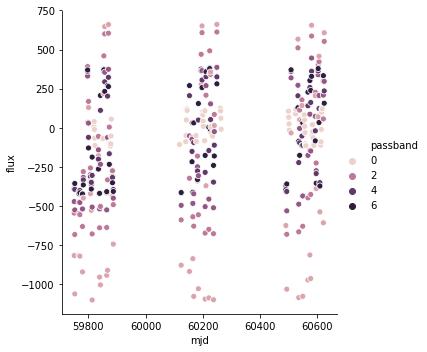

In [6]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 615'))

## obj713 

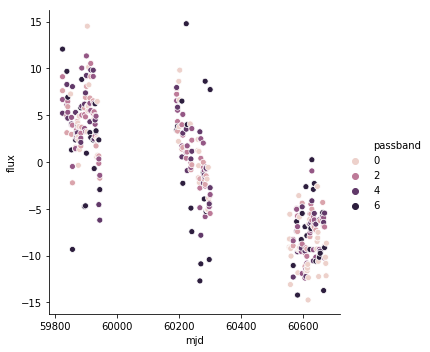

In [7]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 713'))

# XMeans

In [8]:
class XMeans:
    def __init__(self, k_init=2, **k_means_args):
        self.k_init = k_init
        self.k_means_args = k_means_args
    
    def fit(self, X):
        self.__clusters = []
        
        clusters = self.Cluster.build(X, KMeans(self.k_init, **self.k_means_args).fit(X))
        self.__recursively_split(clusters)
        
        self.labels_ = np.empty(X.shape[0], dtype=np.intp)
        for i, c in enumerate(self.__clusters):
            self.labels_[c.index] = i
            
        self.cluster_centers_ = np.array([c.center for c in self.__clusters])
        self.cluster_log_likelihoods_ = np.array([c.log_likelihood() for c in self.__clusters])
        self.cluster_sizes_ = np.array([c.size for c in self.__clusters])
        
        return self
    
    def __recursively_split(self, clusters):
        for cluster in clusters:
            if cluster.size <= 3:
                self.__clusters.append(cluster)
                continue
            k_means = KMeans(2, **self.k_means_args).fit(cluster.data)
            c1, c2 = self.Cluster.build(cluster.data, k_means, cluster.index)
            
            beta = np.linalg.norm(c1.center - c2.center) / np.sqrt(c1.cov + c2.cov)
            alpha = 0.5 / stats.norm.cdf(beta)
            bic = -2 * (cluster.size * np.log(alpha) + 
                        c1.log_likelihood() + c2.log_likelihood()) + 2 * cluster.df * np.log(cluster.size)
            
            if bic < cluster.bic():
                self.__recursively_split([c1, c2])
            else:
                self.__clusters.append(cluster)
        
    class Cluster:
        @classmethod
        def build(cls, X, k_means, index=None):
            if type(index) == type(None):
                index = np.array(range(0, X.shape[0]))
            labels = range(0, k_means.get_params()["n_clusters"])
            return tuple(cls(X, index, k_means, label) for label in labels)
        
        def __init__(self, X, index, k_means, label):
            self.data = X[k_means.labels_ == label]
            self.index = index[k_means.labels_ == label]
            self.size = self.data.shape[0]
            self.df = self.data.shape[1] * (self.data.shape[1] + 3) / 2
            self.center = k_means.cluster_centers_[label]
            self.cov = np.cov(self.data.T)
            
        def log_likelihood(self):
            return sum(
                stats.multivariate_normal.logpdf(x, self.center, self.cov)
                for x in self.data
            )
        
        def bic(self):
            return -2 * self.log_likelihood() + self.df * np.log(self.size)

In [45]:
def elbow(obj_id):
    data = train.query("object_id == @obj_id").mjd.values.reshape([-1, 1])
    kms = [KMeans(n_clusters=i, n_jobs=-1).fit(data) for i in range(2, 6)]
    inertias = [km.inertia_ for km in kms]
    diff1 = inertias[0] - inertias[1]
    diff2 = inertias[1] - inertias[2]
    diff3 = inertias[2] - inertias[3]
    if diff1 / diff2 > diff2 / diff3:
        return kms[1].predict(data)
    else:
        return kms[2].predict(data)

In [16]:
def elbow_df(d):
    data = d.mjd.values.reshape([-1, 1])
    kms = [KMeans(n_clusters=i, n_jobs=-1).fit(data) for i in range(2, 6)]
    inertias = [km.inertia_ for km in kms]
    diff1 = inertias[0] - inertias[1]
    diff2 = inertias[1] - inertias[2]
    diff3 = inertias[2] - inertias[3]
    if diff1 / diff2 > diff2 / diff3:
        return kms[1].predict(data)
    else:
        return kms[2].predict(data)

In [19]:
new_df = train.groupby("object_id").apply(lambda x: elbow_df(x))

In [22]:
new_df.to_frame("cluster")

,cluster
object_id,
615,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
713,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
730,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
745,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1124,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
1227,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1598,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1632,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1920,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [30]:
new_df = new_df.to_frame("cluster").apply(lambda x: x.apply(pd.Series).stack()).reset_index().drop("level_1", axis=1)

In [42]:
new_df.astype({"cluster": int}, inplace=True)

,object_id,cluster
0,615,1
1,615,1
2,615,1
3,615,1
4,615,1
5,615,1
6,615,1
7,615,1
8,615,1
9,615,1


In [43]:
new_df

,object_id,cluster
0,615,1.0
1,615,1.0
2,615,1.0
3,615,1.0
4,615,1.0
5,615,1.0
6,615,1.0
7,615,1.0
8,615,1.0
9,615,1.0


In [36]:
pd.concat([train, new_df.drop("object_id", axis=1)], axis=1)

,object_id,mjd,passband,flux,flux_err,detected,cluster
0,615,59750.4229,2,-544.810303,3.622952,1,1.0
1,615,59750.4306,1,-816.434326,5.553370,1,1.0
2,615,59750.4383,3,-471.385529,3.801213,1,1.0
3,615,59750.4450,4,-388.984985,11.395031,1,1.0
4,615,59752.4070,2,-681.858887,4.041204,1,1.0
5,615,59752.4147,1,-1061.457031,6.472994,1,1.0
6,615,59752.4224,3,-524.954590,3.552751,1,1.0
7,615,59752.4334,4,-393.480225,3.599346,1,1.0
8,615,59752.4435,5,-355.886780,10.421921,1,1.0
9,615,59767.2968,2,-548.013550,3.462291,1,1.0


In [ ]:
def add_cluster(df):
    new_df = df.groupby("object_id", as_index=False).progress_apply(lambda x: elbow_df(x))
    new_df.to_frame("cluster")
    

In [54]:
dfs = []
for obj_id in train.object_id.unique():
    dfs += elbow(obj_id).tolist()
train["cluster"] = dfs

In [55]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected,cluster
0,615,59750.4229,2,-544.810303,3.622952,1,2
1,615,59750.4306,1,-816.434326,5.553370,1,2
2,615,59750.4383,3,-471.385529,3.801213,1,2
3,615,59750.4450,4,-388.984985,11.395031,1,2
4,615,59752.4070,2,-681.858887,4.041204,1,2


In [56]:
train.to_csv(f"{data_dir}train_with_cluster.csv", index=False)

# cluster毎にもみてみる

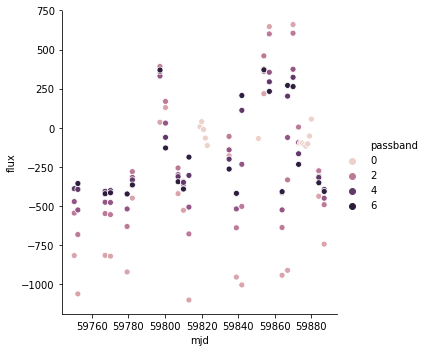

In [57]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 615 & cluster == 2'))

# basic 

In [292]:
agg = basic(train)

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 27.59it/s]


In [293]:
agg.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,mjd_diff_det
object_id,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,0.293128,3245.366349,2741.539785,-1.548319,0.200096,2704.641265,2893.344217,-1.592820,0.125268,873.7903
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,-0.167176,50.414646,203.892482,-1.190245,-0.064134,100.473776,143.963093,-0.797047,0.218182,846.8017
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,2.662075,219.745132,202.532898,6.081065,2.537802,231.509177,199.286370,3.583130,1.680352,78.7737
745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,3.751603,735.528417,680.055280,13.747434,3.476420,591.037583,523.503586,12.134629,3.170857,123.6872
1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,3.603208,574.553907,524.107264,16.377058,3.904008,393.114268,357.907185,14.434470,3.657305,133.9113


In [321]:
agg = with_cluster(train)

In [322]:
agg.head()

,mjd_size_min,mjd_size_max,mjd_size_std,mjd_size_skew,passband_min_min,passband_min_max,passband_min_std,passband_min_skew,passband_max_min,passband_max_max,...,flux_dif2_std,flux_dif2_skew,flux_w_mean_min,flux_w_mean_max,flux_w_mean_std,flux_w_mean_skew,flux_dif3_min,flux_dif3_max,flux_dif3_std,flux_dif3_skew
object_id,,,,,,,,,,,,,,,,,,,,,
615,109,122,7.234178,-1.694891,0,0,0.0,0.0,5,5,...,15.617746,-0.575938,-403.311541,-232.728253,85.370109,-0.222187,-7.477284,-4.363691,1.564932,-0.521814
713,98,127,16.196707,-1.702387,0,0,0.0,0.0,5,5,...,66.887312,1.706627,-9.435739,6.489214,8.019028,-0.604469,-1.587414,158.471197,90.929076,1.725529
730,100,122,11.135529,0.782152,0,0,0.0,0.0,5,5,...,79.455365,0.444992,-1.115807,26.798993,15.683078,1.712546,-25.536497,54.142804,40.478672,0.881236
745,105,125,10.583005,-1.457863,0,0,0.0,0.0,5,5,...,1923.615782,-1.673311,0.047929,153.268512,88.230136,1.731888,1.460171,474.462318,265.251953,1.709632
1124,109,122,7.234178,-1.694891,0,0,0.0,0.0,5,5,...,271.791644,1.633052,-0.357925,88.355526,50.782628,1.730281,-77.268514,16.965649,50.577235,-1.556086


# target 92はぐちゃぐちゃしている？

In [58]:
target92 = meta.query("target == 92")

In [59]:
target92.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
69,12695,51.855469,-28.630989,224.733260,-55.649872,1,0.0,0.0,0.0,NaN,0.009,92
150,26161,359.415588,-46.768478,327.729895,-67.686097,1,0.0,0.0,0.0,NaN,0.009,92
156,26783,150.820312,1.641510,237.994507,42.358984,1,0.0,0.0,0.0,NaN,0.020,92
162,28391,351.953644,-62.132156,318.777388,-52.347124,1,0.0,0.0,0.0,NaN,0.019,92


In [61]:
train.query("object_id == 12695").head()

,object_id,mjd,passband,flux,flux_err,detected,cluster
22964,12695,59825.2600,2,-1929.206421,9.548068,1,0
22965,12695,59825.2676,1,-2335.402588,11.843999,1,0
22966,12695,59825.2752,3,-1771.598267,8.997466,1,0
22967,12695,59825.2862,4,-1813.425293,9.429395,1,0
22968,12695,59825.2971,5,-1907.173218,12.462203,1,0


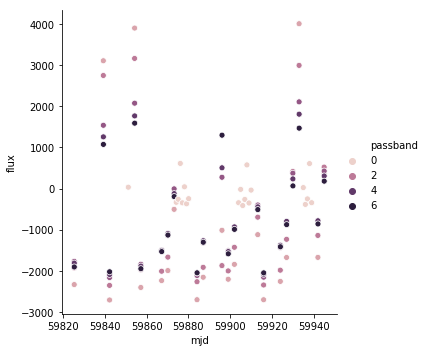

In [62]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 12695 & cluster == 0'))

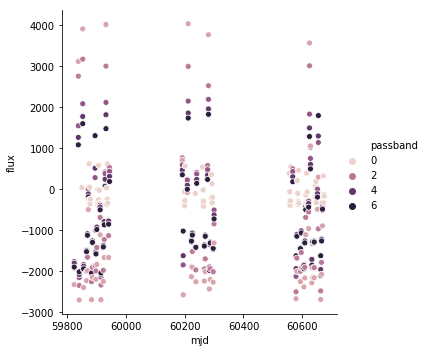

In [63]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 12695'))

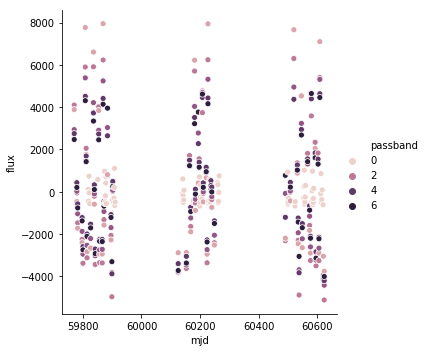

In [64]:
 sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 26161'))

In [66]:
train92 = train.query("object_id == @target92.object_id.unique().tolist()")

In [71]:
train92.head()

,object_id,mjd,passband,flux,flux_err,detected,cluster
0,615,59750.4229,2,-544.810303,3.622952,1,2
1,615,59750.4306,1,-816.434326,5.553370,1,2
2,615,59750.4383,3,-471.385529,3.801213,1,2
3,615,59750.4450,4,-388.984985,11.395031,1,2
4,615,59752.4070,2,-681.858887,4.041204,1,2


In [70]:
train92.groupby(["object_id", "cluster", "passband"]).agg({
    "flux": ["mean", "std", "max", "min"]
})

flux                                       
                                   mean          std          max          min
object_id cluster passband                                                    
615       0       0           27.779471    79.917123   125.182808  -107.080536
                  1         -381.395373   665.386672   660.626343 -1098.651489
                  2         -117.352300   498.811228   611.984558  -676.669189
                  3          -96.647082   358.106729   386.311920  -511.148254
                  4          -12.581387   287.342583   381.953735  -417.145325
                  5            6.196703   281.174549   378.118225  -413.673431
          1       0           -5.390676    86.485882   121.411896  -114.774445
                  1         -282.948110   623.982645   655.284058 -1084.891113
                  2          -29.700736   441.885442   586.178345  -680.489441
                  3          -28.753814   316.512938   445.737061  -530.644592
                  4           30.701212   266.015218   362.888550  -406.733521
                  5           31.119736   271.907699   378.188141  -395.406128
          2       0          -56.275897    60.018378    55.567715  -116.913223
                  1         -477.766336   541.727040   659.486694 -1100.440063
                  2         -237.327169   428.991435   604.344543  -681.858887
                  3         -219.758191   321.576771   373.986511  -524.954590
                  4         -164.309354   294.856591   374.446442  -422.184509
                  5         -161.964772   302.387262   370.346283  -422.815094
12695     0       0         -103.654362   338.415558   611.858887  -413.282684
                  1         -949.601698  2128.580053  4010.295410 -2710.554932
                  2         -817.133104  1790.788013  3165.779541 -2355.710205
                  3         -626.768461  1335.708397  2109.788818 -2164.686279
                  4         -661.983494  1236.958851  1809.342407 -2089.458008
                  5         -700.573268  1221.820057  1591.039062 -2050.541260
          1       0         -116.026441   282.999769   542.409546  -402.556458
                  1        -1216.787429  1595.674669  3559.982910 -2697.105957
                  2        -1050.230600  1393.480409  3003.204590 -2510.944092
                  3         -716.668913  1123.692931  1824.859619 -2133.522705
                  4         -726.568402  1044.911014  1487.305786 -1967.529541
                  5         -729.206737  1044.547216  1789.064575 -1948.053223
...                                 ...          ...          ...          ...
128369913 0       4        -1422.931131  2740.851212  2227.580322 -4329.245117
                  5        -2397.919155  2451.494683  2859.387695 -4284.089355
          1       0          189.984802   874.564613   703.000916  -819.832031
                  1          537.301758  4307.621038  4128.385742 -4238.791504
                  2         -351.750087  3467.114143  4104.265137 -6062.566406
                  3        -2180.033203  2692.705456  2133.618164 -4519.630859
                  4        -1561.934542  2683.681386  1988.769409 -4354.295410
                  5         -274.525274  2350.071165  2243.905273 -4345.728516
          2       2         2819.988078  1118.174662  3623.548340  1542.974976
                  3        -4523.751953          NaN -4523.751953 -4523.751953
                  4          900.536168  2648.195413  2908.017822 -4379.547363
                  5        -1516.355326  2703.953776  2531.715820 -4418.948730
128534658 0       0           62.014839          NaN    62.014839    62.014839
                  1          193.370819   323.676619   422.244751   -35.503113
                  2          193.524319   140.534552   275.541534    31.252186
                  3          122.998736   242.077058   294.173065   -48.175594
                  4          139.322332   156.552319   456.748291   -17.159512
      

In [82]:
train92.groupby(["object_id", "cluster"]).agg({
    "flux": ["mean", "max", "min"]
})

flux                           
                          mean           max          min
object_id cluster                                        
615       0         -87.738928    660.626343 -1098.651489
          1         -45.059588    655.284058 -1084.891113
          2        -232.085164    659.486694 -1100.440063
12695     0        -647.602782   4010.295410 -2710.554932
          1        -693.406501   3559.982910 -2697.105957
          2        -510.138358   4030.413086 -2584.906738
26161     0        -137.702907   7664.928223 -5123.502441
          1          25.162980   7950.507812 -4971.304688
          2         306.634123   7944.709473 -3837.514648
26783     0        -821.649404   2379.075439 -2661.665039
          1        -315.414502   4327.206055 -2540.763916
          2        -485.002167   3123.720947 -2578.593506
28391     0         656.353594  11812.591797 -6797.693359
          1         363.582097  11828.508789 -6410.056152
          2       -1316.600790  12028.020508 -7593.234375
31310     0        -673.786093   4398.535645 -6032.873047
          1       -1076.416647   4445.966309 -5372.423340
          2        -455.333502   4499.947754 -5528.877441
43509     0         200.074343   5665.889160 -1983.908936
          1         453.767179   7053.526855 -2102.506592
          2         588.489037   6799.293457 -1800.207764
49389     0          -2.237685   2817.257568 -1725.059204
          1        -462.685007   1636.498169 -1900.045044
          2        -412.558647    991.443848 -1712.876953
51987     0         234.145978   2662.985107 -2436.261719
          1        -399.314349   2612.233398 -2096.853516
          2         126.712379   2654.203857 -1983.238770
61407     0        -143.756295   5094.384766 -4458.124023
          1        -804.817851   5060.823242 -4572.488281
          2         -39.660541   5068.730469 -4572.292969
...                        ...           ...          ...
120820188 2        2302.243758   9539.746094 -3022.612549
120903979 0         227.667538   4015.596680 -4719.286133
          1         -56.301126   3830.410645 -4529.129883
          2        -169.969683   2900.137939 -4548.254883
120966302 0          86.635719   1167.374268  -544.908997
          1          95.793925    907.983765  -483.856903
          2         178.726179    605.485657  -330.757019
122077687 0          57.994126    254.122787  -130.970871
          1          56.192614    248.853775  -131.496124
          2          62.872794    250.501465  -142.301254
123056998 0         321.969309  10018.845703 -5280.544922
          1        1987.775692  15949.981445 -4937.671875
          2        2094.548435  20094.195312 -3705.353516
123266232 0        3578.493884  19861.597656 -2217.195312
          1        3528.950818  17185.054688 -1922.561890
          2        3698.877516  20427.294922 -2415.956299
125439857 0        -575.249513   3107.670166 -5200.120605
          1        -698.783252   2030.508667 -3685.937256
          2       -1077.180559   1697.449951 -4339.253418
          3        -381.251482   2591.374023 -3171.151123
127175591 0          71.313200    516.350281  -352.123901
          1          98.855303    975.745911  -586.296143
          2          38.355739    980.524231  -610.089050
          3          84.205566    702.451477  -549.668457
128369913 0        -886.005151   4809.873047 -5393.260742
          1        -743.624891   4128.385742 -6062.566406
          2        -170.361624   3623.548340 -4523.751953
128534658 0         114.871863    456.748291  -138.097290
          1         144.031325    717.291443  -164.333405
          2         108.371026    649.265686  -154.702301

[810 rows x 3 columns]

In [83]:
def cluster_mean_diff(df):
    new_df = df.groupby(["object_id", "cluster"]).agg({
        "flux": ["mean", "max", "min"]
    })
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns.tolist()])
    new_df["normalized_mean"] = new_df["flux_mean"] / (new_df["flux_max"] - new_df["flux_min"])
    new_df.reset_index(inplace=True)
    return new_df.groupby("object_id").agg({
        "normalized_mean": "std"
    })

In [84]:
cluster_mean_diff(train92)

,normalized_mean
object_id,
615,0.055573
12695,0.016909
26161,0.018687
26783,0.059601
28391,0.055211
31310,0.032971
43509,0.021180
49389,0.082242
51987,0.070714


In [104]:
passband_std_difference(train92)

3.0171613048435124

In [107]:
passband_std_difference(train92.query("object_id == @train92.object_id.unique()[0]"))

8.087117616905209

# target88

In [72]:
target88 = meta.query("target == 88")
target88.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
20,3489,150.117188,2.836105,236.124718,42.483719,1,1.1330,1.4377,0.2168,45.0753,0.016,88
22,4088,0.965665,-46.375080,325.845907,-68.579427,1,0.4833,0.4644,0.0321,42.0691,0.007,88
37,7315,2.071130,-45.191612,325.606223,-69.989264,1,0.1330,0.1337,0.0171,38.9942,0.011,88
38,7409,352.398651,-62.696659,318.017427,-51.967966,1,3.4451,0.5176,1.2609,42.3516,0.020,88


In [73]:
train88 = train.query("object_id == @target88.object_id.unique().tolist()")

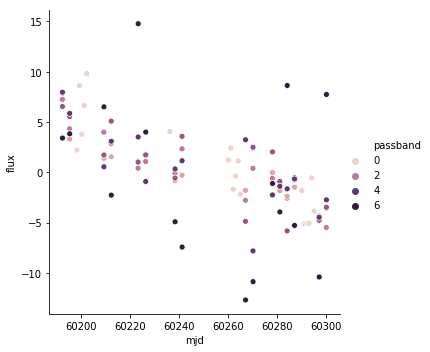

In [74]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 713 & cluster == 0'))

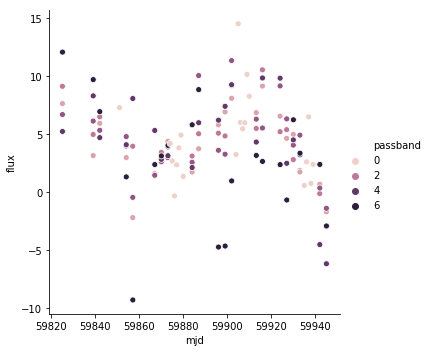

In [75]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 713 & cluster == 1'))

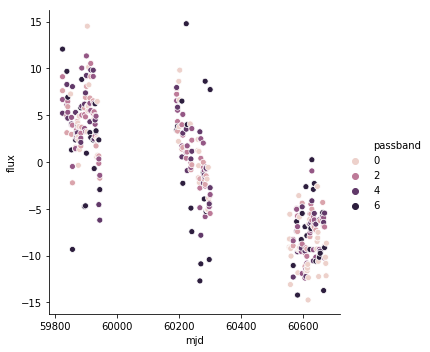

In [76]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 713'))

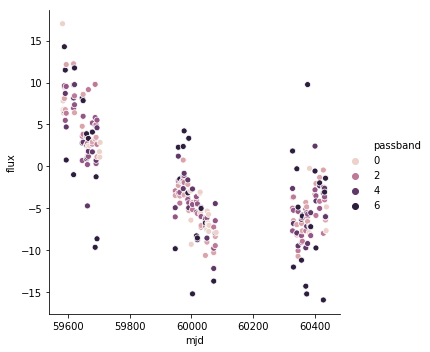

In [77]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 3489'))

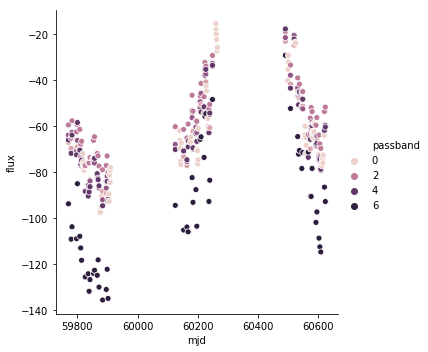

In [78]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 4088'))

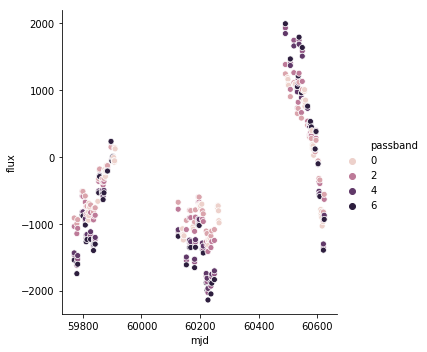

In [79]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 7315'))

In [100]:
train88.groupby(["object_id", "cluster", "passband"]).agg({
    "flux": "std"
}).reset_index().groupby("passband")["flux"].mean()

29.08035922423329

In [105]:
passband_std_difference(train88)

1.848153914567063

In [127]:
train88.query("object_id == 713").groupby(["cluster", "passband"]).agg({
    "flux": ["min", "max"]
})

flux           
                        min        max
cluster passband                      
0       0         -5.132619   9.813441
        1         -4.334117   7.834616
        2         -5.492156   7.250862
        3         -5.832908   6.543319
        4         -7.822262   7.960829
        5        -12.699218  14.770886
1       0         -0.354117  14.509829
        1         -2.223347   9.129021
        2         -3.002108  10.529041
        3         -1.422123  11.330316
        4         -6.208874   9.827934
        5         -9.332252  12.060948
2       0        -14.735178  -2.605739
        1        -11.715749  -4.317381
        2        -10.067919  -4.490414
        3        -12.394593  -0.950650
        4        -12.286801  -4.143107
        5        -14.211164   0.243241

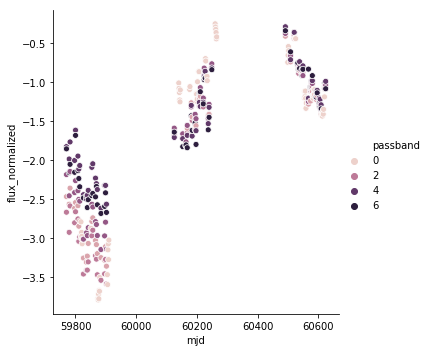

In [135]:
sns.relplot(x="mjd", y="flux_normalized", hue="passband", data=linear_slope(train88).query("object_id == 4088"))

# Target42

In [117]:
target42 = meta.query("target == 42")

In [118]:
target42.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
7,1632,348.595886,-63.072620,320.023289,-50.713060,1,0.6857,0.7014,0.0100,43.1524,0.021,42
11,2103,346.500000,-62.320400,321.951129,-50.736054,1,0.1695,0.5409,0.2283,42.4667,0.020,42
12,2300,359.446716,-44.201530,331.730015,-69.805709,1,0.2360,2.7474,0.5335,46.7959,0.010,42
18,3285,150.820312,1.641510,237.994507,42.358984,1,0.1610,0.1818,0.0079,39.7258,0.020,42


In [119]:
train42 = train.query("object_id == @target42.object_id.values.tolist()")

In [120]:
train42.head()

,object_id,mjd,passband,flux,flux_err,detected,cluster
702,730,59798.3205,2,1.177371,1.364300,0,1
703,730,59798.3281,1,2.320849,1.159247,0,1
704,730,59798.3357,3,2.939447,1.771328,0,1
705,730,59798.3466,4,2.128097,2.610659,0,1
706,730,59798.3576,5,-12.809639,5.380097,0,1


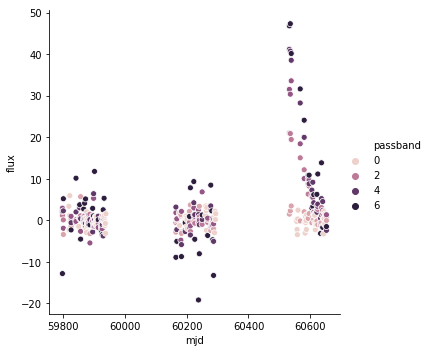

In [121]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 730'))

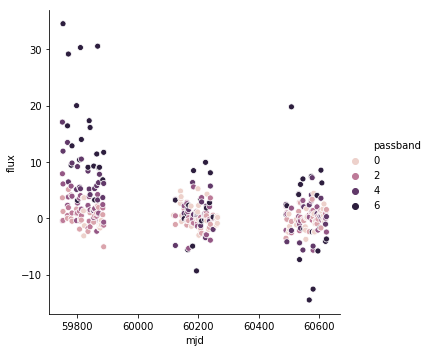

In [122]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 1632'))

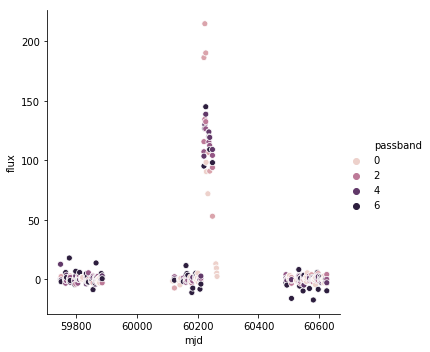

In [123]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 2103'))

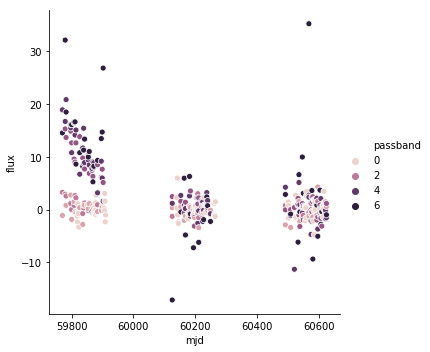

In [124]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 2300'))

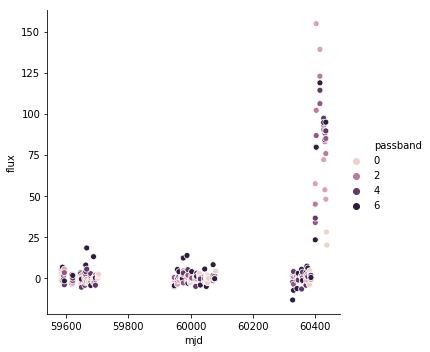

In [125]:
sns.relplot(x='mjd', y='flux', hue='passband', data=train.query('object_id == 3285'))

In [182]:
train42.groupby(["object_id", "cluster", "passband"]).agg({
    "flux": ["mean", "std"]
}).unstack()

flux                                                  \
                         mean                                                   
passband                    0           1           2           3           4   
object_id cluster                                                               
730       0         -0.294553    0.468976    7.984183   10.452110   13.863882   
          1         -0.138009   -0.108744    0.125382   -0.256701    0.526297   
          2          0.500703    0.111615   -0.310820    0.348476   -0.754789   
1632      0         -0.146278    0.489837    0.435755    2.481592    7.327400   
          1         -0.344800    0.231693    0.415131    0.070901   -0.110595   
          2          0.735335   -0.438207    0.320835    0.522631    0.648553   
2103      0         12.419401   48.495070   42.288318   40.835138   43.578548   
          1          0.436393    0.411928   -0.529502    0.323108   -0.153849   
          2         -0.222814    0.430287   -0.096381    0.612772    0.278315   
2300      0          0.370693   -0.299823    0.032541   -0.084232   -0.403413   
          1         -0.107136    0.194044    1.009914   10.151348   11.182636   
          2          0.297863   -0.444381    0.264374    0.791803    0.590786   
3285      0          0.368145   -0.223567   -0.444821    0.126599   -0.976441   
          1          9.935043   32.603800   32.599551   30.674388   31.246082   
          2          0.092832   -0.356991   -0.138639   -0.090132    0.240704   
4132      0          0.275800    0.009248   -0.381845   -0.034686    0.447853   
          1         -0.097851   -0.236240   -0.008645    0.215049   -0.637821   
          2          0.115275    4.178231   10.893463   23.123816    6.965536   
4220      0         90.698526  126.748791  130.802953  131.925401  134.847863   
          1         -0.215767   -0.203251    0.006772    0.126502   -0.370909   
          2         -0.347584    0.387253   -0.500528    0.316794   -0.124414   
5527      0         -0.104791    0.065695    0.714352    0.019681    2.888464   
          1         18.241670   29.194214   85.590606  153.215737  208.890150   
          2          0.284061    0.549934    4.346901   23.879734   77.984380   
7033      0          0.097587    0.277718    0.694075   -0.618159   -0.313723   
          1        180.599782  840.566735  846.728614  895.519496  836.678384   
          2          0.023532   -0.391394    0.175771   -0.026754    0.712136   
9936      0          0.278828    0.292818    0.066669    0.253764   -0.523539   
          1         -0.395799    2.212438   10.993235   14.430547   22.571790   
          2          0.228053   -0.794060   -0.015554    0.148571    0.236937   
...                       ...         ...         ...         ...         ...   
129237530 1          0.925860    0.133709    9.172602   29.345594   25.933754   
          2         -4.788775   -2.959287   35.227598   -2.141530   25.431008   
129259953 0         13.726751   74.820387  114.499328   47.960644  110.227093   
          1          4.990264   -0.511990    5.233714   22.258154   21.867416   
          2         11.405842   -0.894060   -1.794501    5.288963    5.567135   
129311413 0          9.536127         NaN    3.340205    5.285690   -0.728324   
          1          1.271167    0.523325    1.534835   10.223098   52.837614   
          2         -7.288191    1.032623   -0.818097    0.939916    2.228680   
129336792 0         -5.458728   -0.409335    1.038527    1.312148    4.480853   
          1         -4.847183   18.382913   83.292281   95.580879   97.603233   
          2         10.223925    0.589104   -0.276530    2.047615    2.923154   
          3         -4.485684         NaN         NaN         NaN    4.557328   
129546183 0          2.842696    1.534702   -0.592322   -1.671674    0.174786   
          1          7.650391   14.756192   17.402708   32.614109    9.011872   
          2         -2.621121   -0.828326    1.917749   

# Target90

In [183]:
target90 = meta.query("target == 90")
train90 = train.query("object_id == @target90.object_id.values.tolist()")

In [185]:
target90.head(10)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
6,1598,347.846710,-64.760857,318.929827,-49.143596,1,0.1352,0.1820,0.0304,39.7279,0.019,90
8,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
10,2072,0.965665,-46.375080,325.845907,-68.579427,1,0.1516,0.1900,0.0104,39.8317,0.007,90
13,2330,359.805206,-46.768478,327.135979,-67.829903,1,0.4541,0.5736,0.2827,42.6207,0.011,90
27,4389,151.699219,3.583322,236.533224,44.205648,1,0.2333,0.2205,0.9667,40.1939,0.016,90
28,4595,349.615387,-63.636005,318.927246,-50.506542,1,0.5919,0.5995,0.0127,42.7370,0.018,90
29,4819,35.332031,-5.979157,172.286722,-59.931743,1,0.3053,0.2870,0.0076,40.8445,0.022,90
31,6180,33.222656,-4.780192,167.515653,-60.396584,1,0.3201,0.2685,0.5211,40.6793,0.018,90


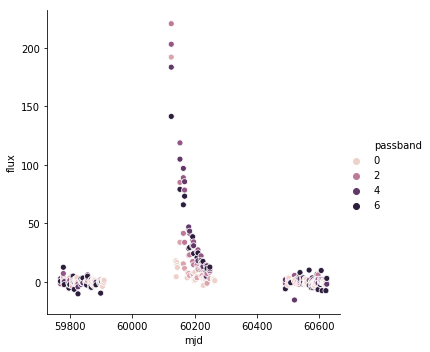

In [186]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train90.query("object_id == 745"))

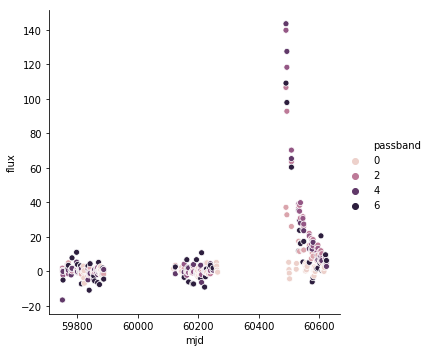

In [187]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train90.query("object_id == 1124"))

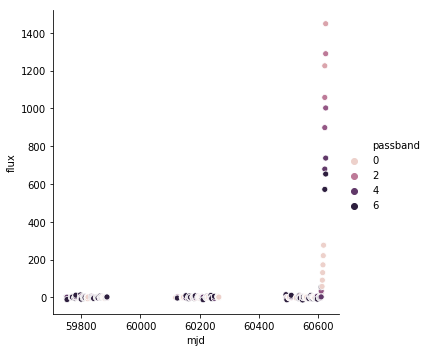

In [188]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train90.query("object_id == 1598"))

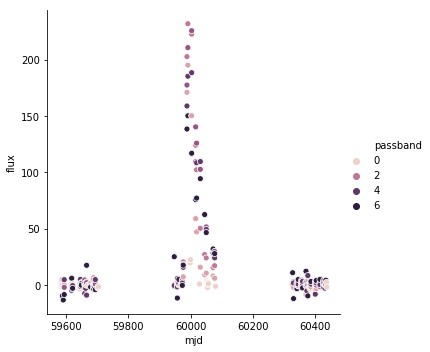

In [189]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train90.query("object_id == 1920"))

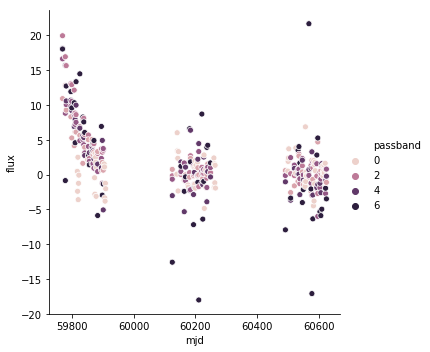

In [190]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train90.query("object_id == 2072"))

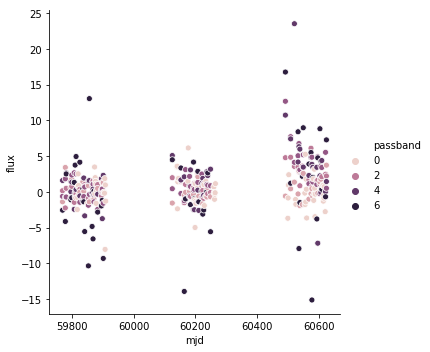

In [191]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train90.query("object_id == 2330"))

In [193]:
target42.head(10)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
7,1632,348.595886,-63.072620,320.023289,-50.713060,1,0.6857,0.7014,0.0100,43.1524,0.021,42
11,2103,346.500000,-62.320400,321.951129,-50.736054,1,0.1695,0.5409,0.2283,42.4667,0.020,42
12,2300,359.446716,-44.201530,331.730015,-69.805709,1,0.2360,2.7474,0.5335,46.7959,0.010,42
18,3285,150.820312,1.641510,237.994507,42.358984,1,0.1610,0.1818,0.0079,39.7258,0.020,42
23,4132,359.811707,-45.191612,329.485675,-69.150905,1,0.0561,0.0556,0.0301,36.9750,0.010,42
26,4220,358.648071,-46.375080,329.462659,-67.716008,1,0.1197,0.1322,0.3351,38.9679,0.009,42
30,5527,347.861847,-61.943836,321.519104,-51.424048,1,0.1315,0.2487,0.8604,40.4896,0.017,42
35,7033,52.207031,-28.291550,224.208534,-55.300157,1,0.0826,0.0850,0.0073,37.9414,0.007,42
52,9936,32.871094,-4.780192,166.959493,-60.615132,1,0.1633,0.0719,0.0389,37.5580,0.017,42


In [194]:
target90.head(10)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
6,1598,347.846710,-64.760857,318.929827,-49.143596,1,0.1352,0.1820,0.0304,39.7279,0.019,90
8,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
10,2072,0.965665,-46.375080,325.845907,-68.579427,1,0.1516,0.1900,0.0104,39.8317,0.007,90
13,2330,359.805206,-46.768478,327.135979,-67.829903,1,0.4541,0.5736,0.2827,42.6207,0.011,90
27,4389,151.699219,3.583322,236.533224,44.205648,1,0.2333,0.2205,0.9667,40.1939,0.016,90
28,4595,349.615387,-63.636005,318.927246,-50.506542,1,0.5919,0.5995,0.0127,42.7370,0.018,90
29,4819,35.332031,-5.979157,172.286722,-59.931743,1,0.3053,0.2870,0.0076,40.8445,0.022,90
31,6180,33.222656,-4.780192,167.515653,-60.396584,1,0.3201,0.2685,0.5211,40.6793,0.018,90


## Clusterごと？

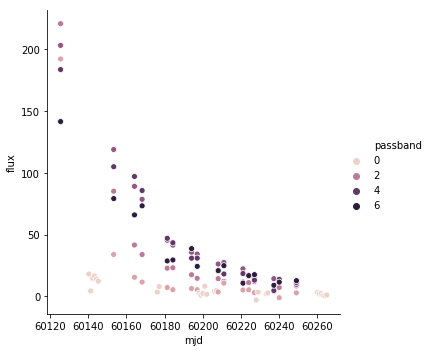

In [195]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train90.query("object_id == 745 & cluster == 0"))

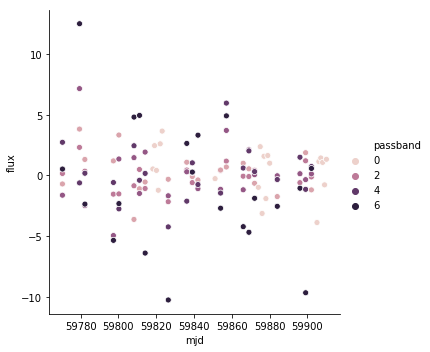

In [196]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train90.query("object_id == 745 & cluster == 1"))

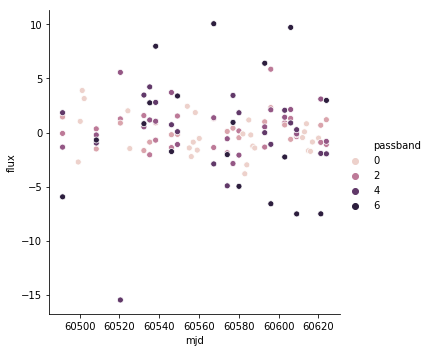

In [197]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train90.query("object_id == 745 & cluster == 2"))

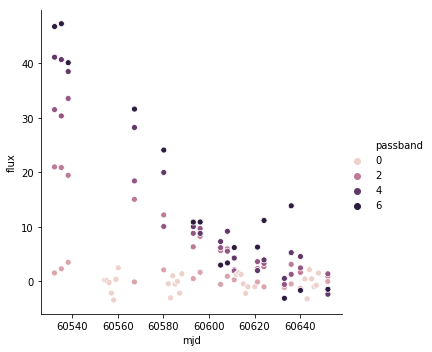

In [199]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train42.query("object_id == 730 & cluster == 0"))

わからず

In [200]:
meta.target.unique()

array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53])

# Target65

In [202]:
target65 = meta.query("target == 65")
train65 = train.query("object_id == @target65.object_id.values.tolist()")

In [203]:
target65.head(10)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0,0.0,0.0,NaN,0.020,65
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0,0.0,0.0,NaN,0.018,65
14,2624,346.655182,-63.260487,320.952196,-50.040935,1,0.0,0.0,0.0,NaN,0.019,65
32,6266,0.929752,-44.597992,328.531426,-70.083244,1,0.0,0.0,0.0,NaN,0.011,65
44,8688,32.695312,-4.929937,166.868469,-60.841230,1,0.0,0.0,0.0,NaN,0.018,65
47,9006,34.277344,-5.079716,169.526841,-59.956640,1,0.0,0.0,0.0,NaN,0.019,65
48,9172,346.655182,-63.260487,320.952196,-50.040935,1,0.0,0.0,0.0,NaN,0.019,65
51,9543,352.132874,-63.636005,317.424173,-51.095855,1,0.0,0.0,0.0,NaN,0.021,65
53,9985,150.820312,3.732834,235.666318,43.572109,1,0.0,0.0,0.0,NaN,0.016,65
56,10349,34.980469,-6.279288,172.180075,-60.389399,1,0.0,0.0,0.0,NaN,0.023,65


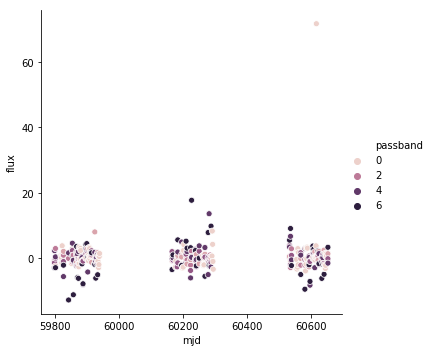

In [204]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train65.query("object_id == 1227"))

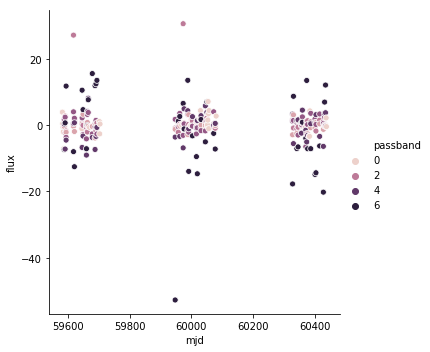

In [205]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train65.query("object_id == 1926"))

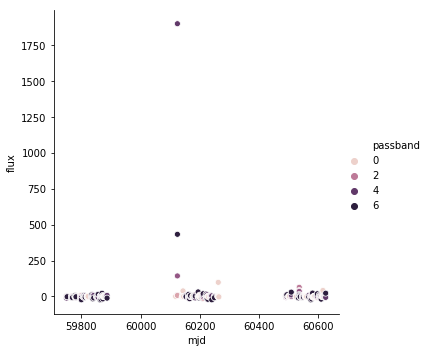

In [207]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train65.query("object_id == 2624"))

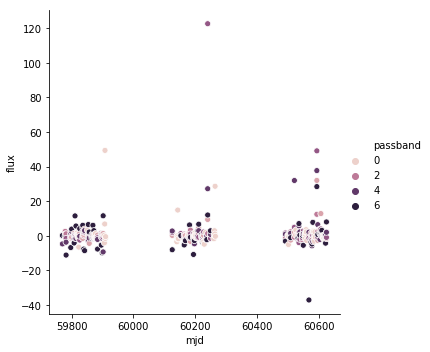

In [208]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train65.query("object_id == 6266"))

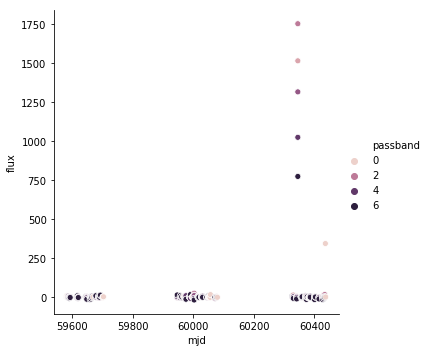

In [216]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train65.query("object_id == 9985"))

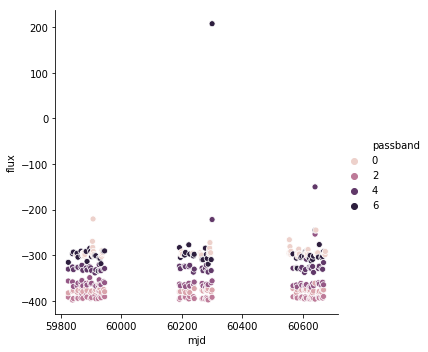

In [214]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train65.query("object_id == 24903"))

In [215]:
train65.groupby(["object_id", "cluster"]).agg({
    "flux": ["std", "min", "max"]
}).unstack()

flux                                                   \
                  std                                              min   
cluster             0           1           2            3           0   
object_id                                                                
1227         3.429256    2.898975    7.406231          NaN   -5.959799   
1926         5.887339    5.139063    7.517302          NaN  -12.523030   
2624       186.568242   10.652798    6.182499          NaN  -23.140690   
6266         8.568089    5.567888   12.934964          NaN  -37.087528   
8688        16.289050   87.356978   98.954078          NaN  -17.361553   
9006         6.287369    4.098914    3.422841          NaN  -17.324352   
9172        18.029899    2.945368    3.213377          NaN  -12.888005   
9543         4.609068    3.316087    4.930412          NaN   -7.778538   
9985       315.562544    5.295018    5.692118          NaN  -17.944614   
10349        4.630543   13.271533    2.849158          NaN  -20.358017   
10796        2.995904   10.125228    2.691684          NaN  -11.880851   
11931        3.251793    4.219769   16.117495          NaN   -8.032848   
12872        3.791853    4.476093    3.135806          NaN  -14.989151   
14080       14.980144    4.596264    6.067683          NaN  -21.360910   
14156       42.498501   40.470534    6.164190          NaN  -14.472964   
15475        9.723904    9.144828  304.239724          NaN  -15.430141   
23795        6.505334    6.460278    4.428824          NaN  -30.959627   
24236        3.541904    2.837650    8.588724          NaN  -11.113924   
24903       44.527957   38.418455   68.628140          NaN -396.182556   
26352        3.463705    4.062526   36.661860          NaN  -21.352465   
26660        8.569047   13.960005    4.117521          NaN  -16.726553   
30066        4.689305    2.779415   27.107563          NaN  -21.132717   
30576        6.790541    6.670477    6.499627          NaN  -57.407772   
31033        4.413921    3.773247    9.670809          NaN  -14.392646   
31605        9.158894   17.508190   10.554776          NaN   -8.666213   
32375        5.496158    2.350712    2.561646          NaN  -10.370481   
33409       11.207974    4.464622   48.360712          NaN  -19.929905   
35555        2.687957    6.540533    3.060178          NaN   -9.092680   
36337        4.463762    3.228156    3.538761          NaN  -13.989249   
36362        6.815888    4.958138    9.535666          NaN   -8.634578   
...               ...         ...         ...          ...         ...   
126644087   19.589482   25.354160   21.168306   109.671973  -68.361191   
126791777   15.268479   19.525659   59.606050    22.444529  -52.096165   
127145862   23.264064   32.421947   18.112793    19.475082  -27.367409   
127521319   40.474133   26.151576   30.562167          NaN  -88.778984   
127843563  115.760361   23.144560   27.453601          NaN  -84.729042   
128113763   25.879834   19.783671   14.563767          NaN  -47.282791   
128123284   11.256466   20.543369   19.188578          NaN  -19.204807   
128167460   25.274007   36.377809  560.272184   127.241040  -19.599001   
128527504   11.873728   29.183408   20.499437    59.122018  -23.385603   
128529993   12.824758   21.551726   30.272541    92.497023  -38.249332   
128765670   23.041218   22.757212   25.350600          NaN  -42.877094   
128814583   42.481696   71.275479   21.457156    38.774951  -63.156490   
128932972   39.040861   19.783760   23.591196          NaN  -41.748825   
128953634   41.506443   85.395962   39.315200    31.329331  -55.312820   
128961480  251.263384   31.175090   43.653307          NaN  -91.773117   
128971260   22.277026   25.855227   34.289445    11.526766  -46.383202   
129030512   21.671895   69.815660   19.474698     6.291601  -72.235924   
129045287   43.635340   25.255306   14.134889    24.473595  -45.150265   
129135543   19.535473   28.056535   21.554631          NaN  -41.885715   
129257128   16.598149

少数の点が平均から大きく外れているイメージ

In [224]:
flux_mean_std = train65.groupby("object_id").agg({
    "flux": ["mean", "std"]
})
flux_mean_std.columns = pd.Index([e[0] + "_" + e[1] for e in flux_mean_std.columns])
flux_mean_std["upper_sigma"] = flux_mean_std["flux_mean"] + 2 *flux_mean_std["flux_std"]
flux_mean_std["lower_sigma"] = flux_mean_std["flux_mean"] - 2 * flux_mean_std["flux_std"]
flux_mean_std.drop(["flux_mean", "flux_std"], axis=1, inplace=True)

In [225]:
train65_m = pd.merge(train65, flux_mean_std, how="left", on="object_id")
train65_m.head(20)

,object_id,mjd,passband,flux,flux_err,detected,cluster,upper_sigma,lower_sigma
0,1227,59798.3205,2,-0.582374,1.376349,0,1,10.292478,-9.558053
1,1227,59798.3281,1,-1.582251,1.165982,0,1,10.292478,-9.558053
2,1227,59798.3357,3,-1.302728,1.869394,0,1,10.292478,-9.558053
3,1227,59798.3466,4,2.371519,2.794304,0,1,10.292478,-9.558053
4,1227,59798.3576,5,-2.830487,5.891528,0,1,10.292478,-9.558053
5,1227,59801.3553,2,3.025061,2.465573,0,1,10.292478,-9.558053
6,1227,59801.3629,1,-2.330685,3.560404,0,1,10.292478,-9.558053
7,1227,59801.3705,3,0.056206,2.365655,0,1,10.292478,-9.558053
8,1227,59801.3815,4,0.480166,2.707553,0,1,10.292478,-9.558053
9,1227,59801.3924,5,-2.835142,5.890770,0,1,10.292478,-9.558053


In [231]:
train65_m["extreme_value"] = ((train65_m["flux"] > train65_m["upper_sigma"]) | (train65_m["flux"] < train65_m["lower_sigma"])).astype(int)

In [233]:
train65_m.groupby("object_id").extreme_value.sum()

object_id
1227          5
1926         14
2624          2
6266         10
8688          3
9006         12
9172          2
9543         16
9985          5
10349         6
10796         4
11931         3
12872        18
14080         9
14156         4
15475         5
23795        17
24236         9
24903         4
26352         1
26660         3
30066         3
30576        10
31033         9
31605         7
32375        10
33409         3
35555        15
36337        16
36362         9
             ..
126644087     1
126791777     3
127145862     8
127521319     4
127843563     2
128113763     9
128123284     9
128167460     2
128527504     1
128529993     5
128765670     5
128814583     5
128932972     6
128953634     3
128961480     1
128971260    10
129030512     5
129045287     5
129135543     6
129257128    10
129399030     5
129416892     1
129964738     2
130108924     9
130330088     6
130386135     2
130622528     2
130727624     5
130739978     5
130772921     2
Name: extreme_

# target16

In [243]:
target16 = meta.query("target == 16")
train16 = train.query("object_id == @target16.object_id.values.tolist()")

In [248]:
target16.head(20)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
15,2677,53.964844,-28.630989,225.142950,-53.813613,1,0.0,0.0,0.0,NaN,0.009,16
24,4171,2.097458,-45.783966,324.737840,-69.478613,1,0.0,0.0,0.0,NaN,0.011,16
39,7566,359.446716,-44.201530,331.730015,-69.805709,1,0.0,0.0,0.0,NaN,0.010,16
42,7756,149.414062,2.238686,236.239766,41.565558,1,0.0,0.0,0.0,NaN,0.017,16
46,8784,34.101562,-5.829153,170.247753,-60.638325,1,0.0,0.0,0.0,NaN,0.019,16
62,11165,150.996094,2.985506,236.647967,43.287350,1,0.0,0.0,0.0,NaN,0.020,16
89,15626,346.130127,-63.072620,321.423103,-50.042305,1,0.0,0.0,0.0,NaN,0.020,16
91,15700,359.415588,-46.768478,327.729895,-67.686097,1,0.0,0.0,0.0,NaN,0.009,16
95,16339,51.328125,-27.447618,222.535046,-55.950727,1,0.0,0.0,0.0,NaN,0.013,16
96,16349,150.820312,3.134927,236.341348,43.230123,1,0.0,0.0,0.0,NaN,0.016,16


In [249]:
target65.head(20)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0,0.0,0.0,NaN,0.020,65
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0,0.0,0.0,NaN,0.018,65
14,2624,346.655182,-63.260487,320.952196,-50.040935,1,0.0,0.0,0.0,NaN,0.019,65
32,6266,0.929752,-44.597992,328.531426,-70.083244,1,0.0,0.0,0.0,NaN,0.011,65
44,8688,32.695312,-4.929937,166.868469,-60.841230,1,0.0,0.0,0.0,NaN,0.018,65
47,9006,34.277344,-5.079716,169.526841,-59.956640,1,0.0,0.0,0.0,NaN,0.019,65
48,9172,346.655182,-63.260487,320.952196,-50.040935,1,0.0,0.0,0.0,NaN,0.019,65
51,9543,352.132874,-63.636005,317.424173,-51.095855,1,0.0,0.0,0.0,NaN,0.021,65
53,9985,150.820312,3.732834,235.666318,43.572109,1,0.0,0.0,0.0,NaN,0.016,65
56,10349,34.980469,-6.279288,172.180075,-60.389399,1,0.0,0.0,0.0,NaN,0.023,65


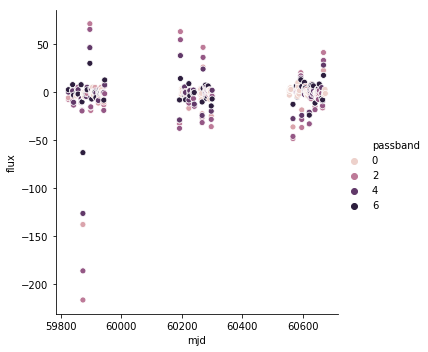

In [245]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train16.query("object_id == 2677"))

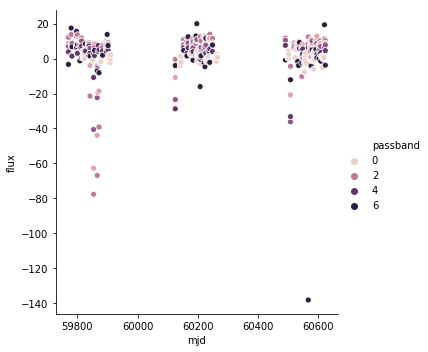

In [247]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train16.query("object_id == 4171"))

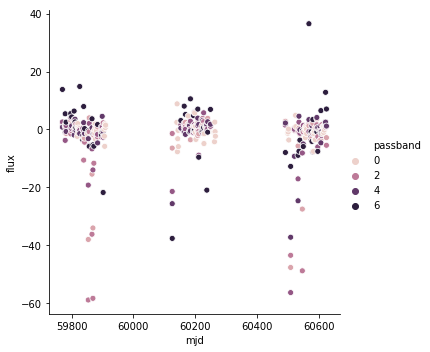

In [250]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train16.query("object_id == 7566"))

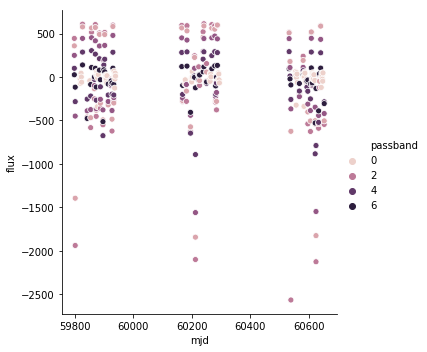

In [251]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train16.query("object_id == 8784"))

あんまわからんけど見分けやすいらしい

# Target67

In [253]:
target67 = meta.query("target == 67")
train67 = train.query("object_id == @target67.object_id.values.tolist()")

In [254]:
target67.head(20)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
16,2922,352.398651,-62.696659,318.017427,-51.967966,1,0.1539,0.1469,0.0094,39.2171,0.020,67
17,3041,346.130127,-63.072620,321.423103,-50.042305,1,0.1069,0.1274,0.0198,38.8800,0.020,67
114,19154,351.382965,-64.011238,317.574052,-50.604657,1,0.2354,2.4138,0.5022,46.4553,0.023,67
163,28636,51.855469,-28.630989,224.733260,-55.649872,1,0.1743,0.4412,0.3366,41.9364,0.009,67
201,34437,152.050781,2.985506,237.495952,44.143927,1,0.2657,0.2629,1.0604,40.6263,0.019,67
219,37872,150.820312,3.134927,236.341348,43.230123,1,0.2517,0.2448,0.0217,40.4506,0.016,67
239,42333,346.562500,-63.448284,320.824720,-49.866957,1,0.1921,0.2046,0.0101,40.0116,0.021,67
262,45349,32.695312,-4.929937,166.868469,-60.841230,1,0.2821,2.6404,0.9837,46.6916,0.018,67
276,48725,53.613281,-28.630989,225.073365,-54.119461,1,0.3658,0.3599,0.1804,41.4145,0.006,67
285,50277,349.046051,-61.943836,320.796530,-51.753706,1,0.3009,0.2478,1.3214,40.4807,0.017,67


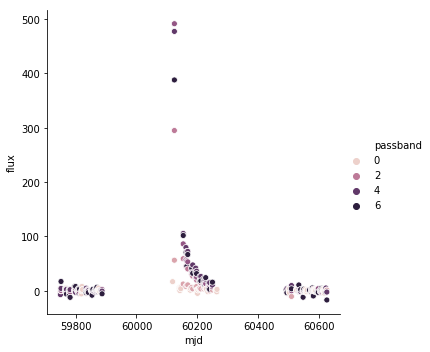

In [255]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train67.query("object_id == 2922"))

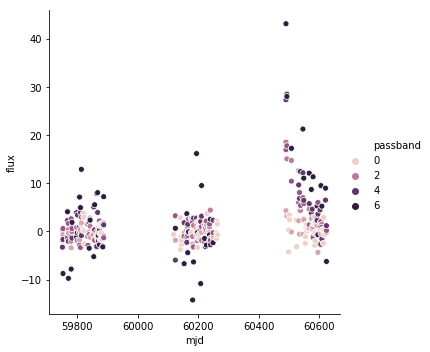

In [256]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train67.query("object_id == 3041"))

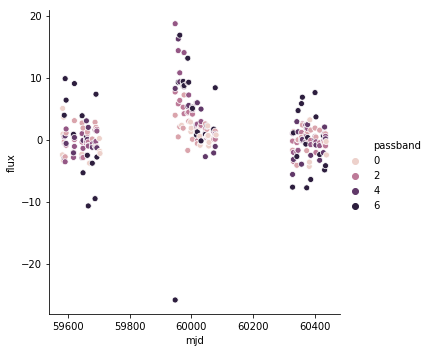

In [257]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train67.query("object_id == 72385"))

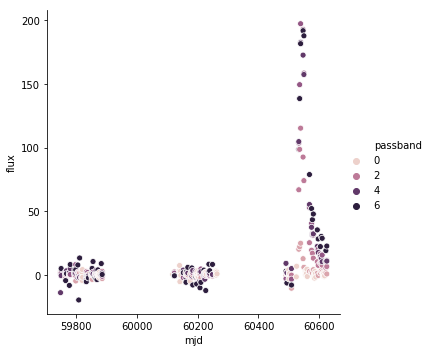

In [258]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train67.query("object_id == 75646"))

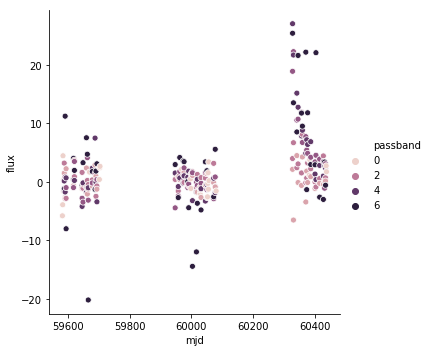

In [259]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train67.query("object_id == 88180"))

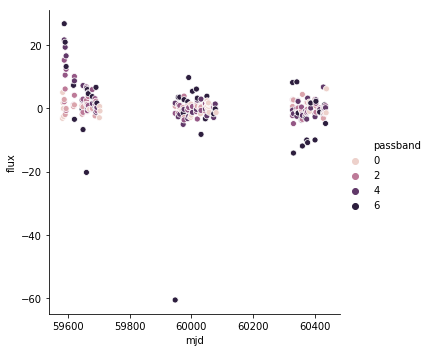

In [260]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train67.query("object_id == 97920"))

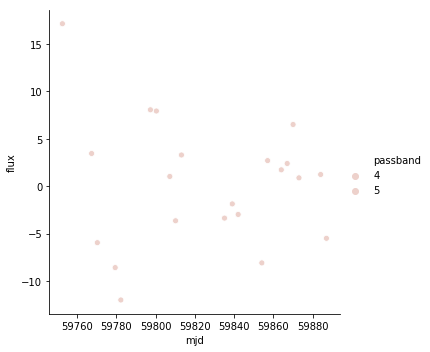

In [267]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train67.query("object_id == 2922 & passband == 5 & cluster == 0"))

わからん

In [268]:
meta.target.unique()

array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53])

# Target95

In [269]:
target95 = meta.query("target == 95")
train95 = train.query("object_id == @target95.object_id.values.tolist()")

In [270]:
target95.head(20)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
19,3423,349.615387,-63.636005,318.927246,-50.506542,1,1.9876,1.1213,0.1591,44.4078,0.018,95
54,10321,358.312500,-44.993881,332.185785,-68.685906,1,1.0833,1.1162,0.1020,44.3954,0.009,95
82,14553,359.805206,-46.768478,327.135979,-67.829903,1,1.1897,1.1667,0.1717,44.5143,0.011,95
129,23539,34.277344,-5.079716,169.526841,-59.956640,1,0.4550,0.2524,0.3112,40.5254,0.019,95
184,31569,346.655182,-63.260487,320.952196,-50.040935,1,1.0133,1.0031,0.0118,44.1084,0.019,95
203,35315,150.468750,3.732834,235.392208,43.283244,1,1.8476,1.5239,0.2256,45.2314,0.020,95
240,42469,2.071130,-45.191612,325.606223,-69.989264,1,1.5989,1.4913,0.1216,45.1735,0.011,95
432,73610,34.277344,-5.079716,169.526841,-59.956640,1,0.8134,1.5079,0.3508,45.2031,0.019,95
444,76304,348.595886,-63.072620,320.023289,-50.713060,1,2.4303,2.6811,1.0262,46.7317,0.021,95
455,77391,346.130127,-63.072620,321.423103,-50.042305,1,1.3214,1.4667,0.1459,45.1288,0.020,95


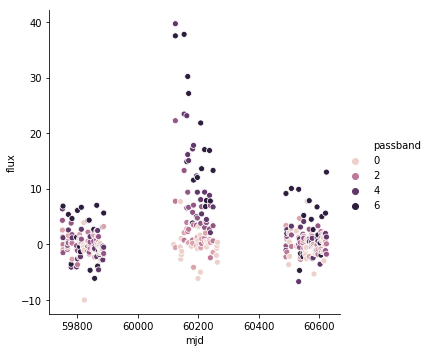

In [271]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train95.query("object_id == 3423"))

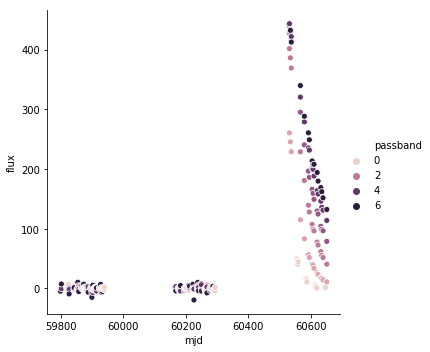

In [272]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train95.query("object_id == 80205"))

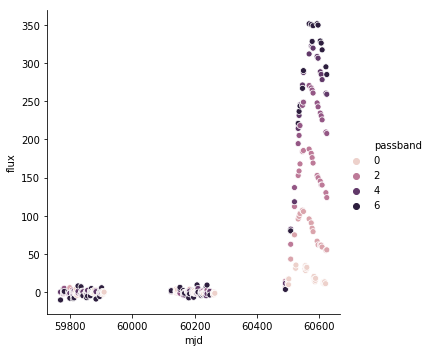

In [273]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train95.query("object_id == 109516"))

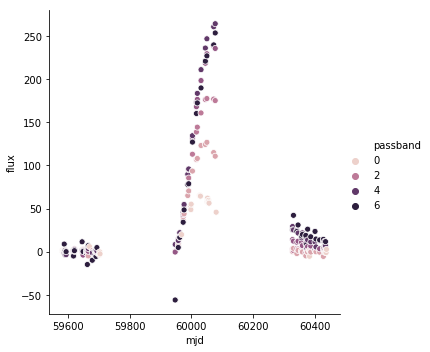

In [275]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train95.query("object_id == 35315"))

In [278]:
train95.groupby(["object_id", "cluster", "passband"]).agg({
    "flux": ["skew", "mean", "std"]
})

flux                        
                                skew        mean         std
object_id cluster passband                                  
3423      0       0         0.576587   -0.278168    2.785502
                  1        -1.206065    0.254725    1.557793
                  2         1.254593    1.413818    2.249652
                  3         2.413721    6.668559    4.825419
                  4         1.526555   13.288099    9.263980
                  5         0.890098   16.758457   10.694861
          1       0         1.270387   -0.495606    2.452360
                  1         0.432876    0.292310    2.009711
                  2        -0.004587   -0.329871    1.235033
                  3         0.226299    0.616064    1.320991
                  4        -0.909274    0.143838    2.638341
                  5         0.063383    3.688169    5.030074
          2       0        -1.838711   -1.324394    3.034679
                  1         0.817301    0.611125    1.990874
                  2        -0.393601   -0.635090    1.389827
                  3         1.095333    0.545168    1.706323
                  4         0.290739   -0.181818    2.707204
                  5        -0.206589    1.435069    4.174154
10321     0       0        -1.037348   73.397832   37.752246
                  1        -1.090156  144.839980   69.400226
                  2        -0.882382  224.246375  117.415117
                  3        -0.703606  239.121790  132.603585
                  4        -0.582293  233.783818  130.459056
                  5        -0.736131  229.205865  126.673618
          1       0         0.544248    0.543421    2.143844
                  1         0.340301   -0.003915    1.254906
                  2        -1.581318    0.051200    1.431398
                  3        -0.396337   -0.648539    1.843172
                  4         0.030576    0.554167    2.293620
                  5        -0.879597   -1.327230    6.587564
...                              ...         ...         ...
128152732 1       5        -0.284249   -3.019574   28.097577
          2       0              NaN   -3.502834    5.632241
                  1              NaN    1.557341    0.818627
                  2        -0.967267   -2.621931    3.535540
                  3         0.378994   -1.099144    3.964224
                  4         0.877751    0.928108    8.315778
                  5         1.186020   -6.276446   15.171592
          3       0        -1.627385    3.238466    6.411697
                  1         1.927415    0.800420    3.093130
                  2         0.400479    1.645082    2.206514
                  3         1.755293   -2.729611    3.111120
                  4        -0.415853   -5.112231    9.650451
                  5         0.598845   11.058045   29.940568
129463916 0       0         1.126750    5.190181   17.903378
                  1         0.746228   37.825575   49.832992
                  2         0.432999   54.651520   57.944160
                  3         0.125270   62.435637   74.280935
                  4         0.754572   59.772764   86.928768
                  5         0.836021   50.792701   75.737729
          1       0        -0.478961   -2.311558    6.498610
                  1        -0.697245    3.194076    3.076529
                  2         0.574487    6.361915    5.091038
                  3         1.401297   13.628648   12.698094
                  4         1.086818    6.349483   21.229574
                  5        -0.064745    2.650127   37.822558
          2       1              NaN   -2.013588         NaN
                  2              NaN    4.897844    4.474657
                  3        -0.030110   -3.680812   13.678920
                  4        -0.181576    0.918308   24.074097
                  5        -1.741263   -9.387522   22.882517

[3312 rows x 3 columns]

# Target62

In [279]:
target62 = meta.query("target == 62")
train62 = train.query("object_id == @target62.object_id.values.tolist()")

In [280]:
target62.head(10)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
21,3910,0.589520,-47.161343,325.385896,-67.769893,1,0.1969,2.6766,0.5926,46.7274,0.009,62
41,7703,53.085938,-28.122234,224.100909,-54.509752,1,0.0830,0.0820,0.2257,37.8568,0.007,62
65,11770,346.130127,-63.072620,321.423103,-50.042305,1,0.1415,0.2171,0.4350,40.1560,0.020,62
105,17370,0.949367,-45.586655,326.991548,-69.251686,1,0.3138,0.3391,0.4176,41.2636,0.013,62
110,18645,358.636353,-46.768478,328.890146,-67.388837,1,0.1640,2.3025,1.1022,46.3306,0.008,62
111,18706,34.277344,-5.679190,170.314930,-60.410322,1,0.1706,0.1766,0.0158,39.6556,0.020,62
115,19213,1.753247,-46.768478,324.030235,-68.498041,1,0.1254,0.1484,0.0086,39.2403,0.014,62
117,20567,351.259003,-64.386185,317.344860,-50.255113,1,0.1549,0.1481,0.2206,39.2350,0.020,62
151,26338,151.171875,2.537361,237.288526,43.169764,1,0.1892,0.2250,0.0141,40.2436,0.024,62
172,29670,1.694561,-45.191612,326.278557,-69.858253,1,0.1135,0.1208,0.0198,38.7544,0.011,62


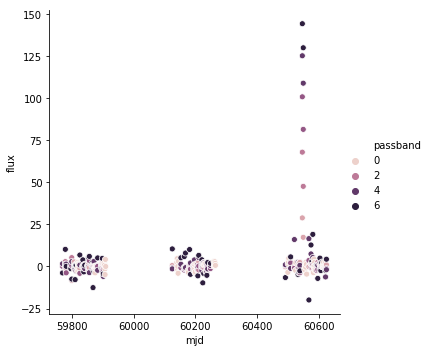

In [281]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train62.query("object_id == 3910"))

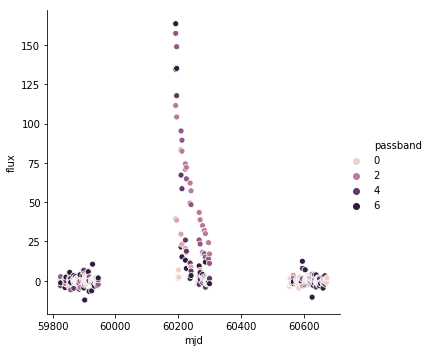

In [282]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train62.query("object_id == 7703"))

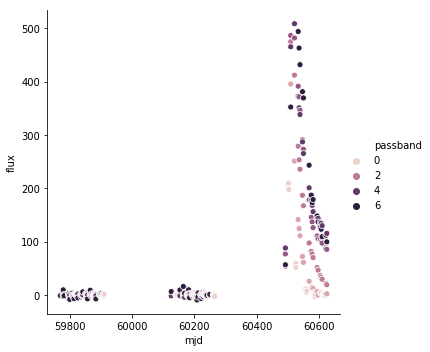

In [283]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train62.query("object_id == 19213"))

# Target15

In [284]:
target15 = meta.query("target == 15")
train15 = train.query("object_id == @target15.object_id.values.tolist()")

In [285]:
target15.head(10)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
25,4173,152.050781,3.284369,237.157374,44.318466,1,0.5149,0.5512,0.0221,42.5158,0.019,15
123,23116,53.261719,-27.615883,223.280041,-54.281374,1,0.8237,0.7520,0.0300,43.3376,0.006,15
572,97406,347.846710,-64.760857,318.929827,-49.143596,1,0.1163,0.0897,0.8592,38.0649,0.019,15
684,113669,351.299988,-62.320400,319.038597,-52.026867,1,0.2914,0.2905,0.0061,40.8748,0.018,15
807,133234,151.523438,3.134927,236.900695,43.803170,1,0.2288,0.2866,0.0891,40.8416,0.019,15
879,148996,51.855469,-26.276812,220.627031,-55.293792,1,0.0258,0.0954,0.0390,38.2066,0.014,15
1578,254618,148.710938,2.836105,235.050801,41.328739,1,0.3407,0.3940,0.0549,41.6459,0.031,15
1723,279292,148.886719,2.686724,235.347248,41.389003,1,0.3048,0.3106,0.0087,41.0422,0.028,15
2120,1135692,177.539062,-18.997131,283.433188,41.542691,0,0.4408,0.4523,0.0146,42.0008,0.037,15
2138,1454581,200.566406,-15.404094,313.821635,46.814793,0,0.1172,0.1386,0.0156,39.0782,0.071,15


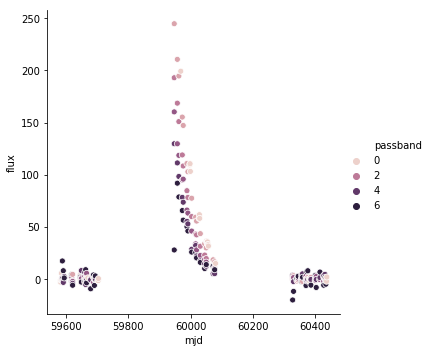

In [286]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train15.query("object_id == 4173"))

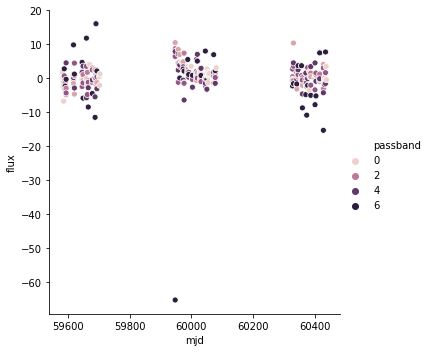

In [287]:
sns.relplot(x="mjd", y="flux", hue="passband", data=train15.query("object_id == 133234"))